In [81]:
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
import logging
import json
import matplotlib.pyplot as plt

In [82]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [187]:
class TrainRouter:
    def __init__(self, tgv_folder, ter_folder):
        self.graph = nx.DiGraph()
        self.stops_info = {}  # Informations sur les arrêts
        self.stop_point_to_area = {}  # Mapping StopPoint vers StopArea
        logger.info("Initialisation du router...")
        self.load_data(tgv_folder, "TGV")
        self.load_data(ter_folder, "TER")
        logger.info(f"Graphe construit avec {self.graph.number_of_nodes()} nœuds et {self.graph.number_of_edges()} arêtes")

    def load_data(self, folder_path, train_type):
        logger.info(f"Chargement des données {train_type} depuis {folder_path}")
        try:
            # Charger les fichiers
            stops_df = pd.read_csv(f"{folder_path}/stops.txt")
            stop_times_df = pd.read_csv(f"{folder_path}/stop_times.txt")
            
            # Créer le mapping StopPoint vers StopArea
            for _, row in stops_df.iterrows():
                stop_id = row['stop_id']
                if row['location_type'] == 0:  # C'est un StopPoint
                    parent_station = row['parent_station']
                    if parent_station:
                        self.stop_point_to_area[stop_id] = parent_station
                    else:
                        self.stop_point_to_area[stop_id] = stop_id
                
                # Stocker les informations de tous les arrêts
                self.stops_info[stop_id] = {
                    'name': row['stop_name'],
                    'lat': row['stop_lat'],
                    'lon': row['stop_lon'],
                    'type': 'area' if row['location_type'] == 1 else 'point'
                }

            logger.info(f"Chargé {len(self.stop_point_to_area)} mappings de points d'arrêt")
            
            # Traiter les horaires
            trip_groups = stop_times_df.groupby('trip_id')
            edges_added = 0
            
            for trip_id, group in trip_groups:
                sorted_stops = group.sort_values('stop_sequence')
                
                for i in range(len(sorted_stops) - 1):
                    current_stop = sorted_stops.iloc[i]
                    next_stop = sorted_stops.iloc[i + 1]
                    
                    # Obtenir les StopPoints
                    current_point_id = current_stop['stop_id']
                    next_point_id = next_stop['stop_id']
                    
                    try:
                        departure_time = self._time_to_minutes(current_stop['departure_time'])
                        arrival_time = self._time_to_minutes(next_stop['arrival_time'])
                        duration = arrival_time - departure_time
                        
                        if duration > 0:
                            # Ajouter l'arête avec les StopPoints
                            self.graph.add_edge(
                                current_point_id,
                                next_point_id,
                                weight=duration,
                                train_type=train_type,
                                departure=current_stop['departure_time'],
                                arrival=next_stop['arrival_time']
                            )
                            edges_added += 1
                            
                    except ValueError as e:
                        logger.warning(f"Erreur de conversion de temps pour le trajet {trip_id}: {e}")
                        continue
            
            logger.info(f"{edges_added} arêtes ajoutées pour {train_type}")
            
        except Exception as e:
            logger.error(f"Erreur lors du chargement des données {train_type}: {e}")
            raise

    def _time_to_minutes(self, time_str):
        try:
            hours, minutes, seconds = map(int, time_str.split(':'))
            return hours * 60 + minutes
        except:
            raise ValueError(f"Format de temps invalide: {time_str}")

    def find_station_ids(self, city_name):
        """Trouve tous les IDs de station correspondant à une ville"""
        city_name_lower = city_name.lower()
        matching_stops = []
        
        for stop_id, info in self.stops_info.items():
            if city_name_lower in info['name'].lower():
                if info['type'] == 'point':  # Si c'est un StopPoint
                    matching_stops.append(stop_id)
                    logger.info(f"Station trouvée pour {city_name}: {info['name']} ({stop_id})")
        
        if not matching_stops:
            logger.warning(f"Aucune station trouvée pour {city_name}")
        
        return matching_stops

    def find_fastest_route(self, start_city, end_city, current_time=None):
        logger.info(f"Recherche d'itinéraire entre {start_city} et {end_city}")
        
        start_stops = self.find_station_ids(start_city)
        end_stops = self.find_station_ids(end_city)
        
        logger.info(f"Stations de départ trouvées: {len(start_stops)}")
        logger.info(f"Stations d'arrivée trouvées: {len(end_stops)}")
        
        if not start_stops or not end_stops:
            return None, None
        
        if current_time is None:
            current_time = datetime.now().strftime('%H:%M:%S')
        
        current_minutes = self._time_to_minutes(current_time)
        logger.info(f"Heure actuelle : {current_time} ({current_minutes} minutes depuis minuit)")
        
        shortest_path = None
        min_duration = float('inf')
        best_route_info = None

        for start_stop in start_stops:
            for end_stop in end_stops:
                try:
                    # Dijkstra personnalisé pour prendre en compte l'heure actuelle
                    path, duration, route_info = self._dijkstra_with_time(start_stop, end_stop, current_minutes)
                    
                    if path and duration < min_duration:
                        min_duration = duration
                        shortest_path = path
                        best_route_info = route_info

                except nx.NetworkXNoPath:
                    logger.warning(f"Pas de chemin trouvé entre {start_stop} et {end_stop}")
                    continue
                except Exception as e:
                    logger.error(f"Erreur lors de la recherche de chemin: {e}")
                    continue
        
        return shortest_path, best_route_info
    
    def _dijkstra_with_time(self, start_stop, end_stop, current_minutes):
        """
        Algorithme de Dijkstra modifié pour prendre en compte l'heure actuelle.
        """
        visited = {}
        pq = [(0, start_stop, current_minutes, [])]  # (total_duration, current_node, current_time, route_info)

        while pq:
            total_duration, current_node, arrival_time, route_info = pq.pop(0)

            if current_node in visited and visited[current_node] <= total_duration:
                continue

            visited[current_node] = total_duration

            if current_node == end_stop:
                return route_info[-1]['to'], total_duration, route_info

            for neighbor, edge_data in self.graph[current_node].items():
                departure_minutes = self._time_to_minutes(edge_data['departure'])
                
                if departure_minutes < arrival_time:
                    # Train déjà parti, ignorer cette arête
                    continue

                wait_time = departure_minutes - arrival_time
                travel_time = edge_data['weight']
                new_total_duration = total_duration + wait_time + travel_time

                new_route_info = route_info + [{
                    'from': self.stops_info[current_node]['name'],
                    'to': self.stops_info[neighbor]['name'],
                    'train_type': edge_data['train_type'],
                    'departure': edge_data['departure'],
                    'arrival': edge_data['arrival']
                }]

                pq.append((new_total_duration, neighbor, departure_minutes + travel_time, new_route_info))
                pq.sort()  # Priorité au temps total minimum

        return None, float('inf'), None

    def format_route(self, route_info, current_time=None):
        if not route_info:
            return "Aucun itinéraire trouvé."
        
        if current_time is None:
            current_time = datetime.now().strftime('%H:%M:%S')
        
        formatted_route = [f"Heure actuelle : {current_time}\n"]
        total_duration = timedelta()
        
        # Calculer le temps d'attente jusqu'au premier train
        first_departure = datetime.strptime(route_info[0]['departure'], '%H:%M:%S')
        current_dt = datetime.strptime(current_time, '%H:%M:%S')
        
        wait_time = (first_departure - current_dt)
        if wait_time.total_seconds() < 0:
            # Si le train est déjà parti, ajouter 24h
            wait_time = timedelta(days=1) + wait_time
        
        formatted_route.append(f"Temps d'attente jusqu'au prochain train : {wait_time}\n")
        
        for segment in route_info:
            departure = datetime.strptime(segment['departure'], '%H:%M:%S')
            arrival = datetime.strptime(segment['arrival'], '%H:%M:%S')
            duration = arrival - departure
            total_duration += duration
            
            formatted_route.append(
                f"{segment['train_type']} : {segment['from']} → {segment['to']}\n"
                f"Départ : {segment['departure']}, Arrivée : {segment['arrival']}\n"
                f"Durée : {duration}\n"
            )
        
        formatted_route.append(f"\nDurée totale du trajet : {total_duration}")
        formatted_route.append(f"Temps total (attente + trajet) : {wait_time + total_duration}")
        
        return "\n".join(formatted_route)

In [188]:
router = TrainRouter("./export_gtfs_voyages", "./export-ter-gtfs-last")

INFO:__main__:Initialisation du router...
INFO:__main__:Chargement des données TGV depuis ./export_gtfs_voyages
INFO:__main__:Chargé 285 mappings de points d'arrêt
INFO:__main__:29346 arêtes ajoutées pour TGV
INFO:__main__:Chargement des données TER depuis ./export-ter-gtfs-last
INFO:__main__:Chargé 5479 mappings de points d'arrêt
INFO:__main__:276046 arêtes ajoutées pour TER
INFO:__main__:Graphe construit avec 5479 nœuds et 13700 arêtes


In [189]:
logger.info("Statistiques du graphe:")
logger.info(f"Nombre de nœuds (gares): {router.graph.number_of_nodes()}")
logger.info(f"Nombre d'arêtes (trajets): {router.graph.number_of_edges()}")

INFO:__main__:Statistiques du graphe:
INFO:__main__:Nombre de nœuds (gares): 5479
INFO:__main__:Nombre d'arêtes (trajets): 13700


In [191]:
current_time = datetime.now().strftime('%H:%M:%S')
path, route_info = router.find_fastest_route("Strasbourg", "Paris", current_time)
if path:
    print("Itinéraire trouvé :")
    print(router.format_route(route_info, current_time))
else:
    print("Aucun itinéraire trouvé.")

INFO:__main__:Recherche d'itinéraire entre Strasbourg et Paris
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCEICE-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCELyria-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCEOUIGO-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCETGV INOUI-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCECar TER-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg (StopPoint:OCETrain TER-87212027)
INFO:__main__:Station trouvée pour Strasbourg: Strasbourg Roethig (StopPoint:OCETrain TER-87212191)
INFO:__main__:Station trouvée pour Paris: Paris Est (StopPoint:OCEICE-87113001)
INFO:__main__:Station trouvée pour Paris: Paris Est (StopPoint:OCEOUIGO-87113001)
INFO:__main__:Station trouvée pour Paris: Paris Est (StopPoint:OCETGV INOUI-87113001)
INFO:__main__:Station trouvée pour Paris: Paris Gare 

Itinéraire trouvé :
Heure actuelle : 17:10:44

Temps d'attente jusqu'au prochain train : 1:08:16

TGV : Strasbourg → Champagne-Ardenne TGV
Départ : 18:19:00, Arrivée : 19:28:00
Durée : 1:09:00

TGV : Champagne-Ardenne TGV → Paris Est
Départ : 20:32:00, Arrivée : 21:14:00
Durée : 0:42:00


Durée totale du trajet : 1:51:00
Temps total (attente + trajet) : 2:59:16


In [169]:
route_info

[{'from': 'Strasbourg',
  'to': 'Mundolsheim',
  'train_type': 'TER',
  'departure': '19:27:00',
  'arrival': '19:32:00'},
 {'from': 'Mundolsheim',
  'to': 'Vendenheim',
  'train_type': 'TER',
  'departure': '19:33:00',
  'arrival': '19:35:00'}]

In [58]:
with open('assets/liste-des-circuits-de-voie.json', 'r', encoding='utf-8') as f:
    voies_data = json.load(f)

with open('assets/gares-de-voyageurs.json', 'r', encoding='utf-8') as f:
    gares_data = json.load(f)

In [59]:
voies_segments = []
for voie in voies_data:
    if 'geo_shape' in voie and 'geometry' in voie['geo_shape']:
        if voie['geo_shape']['geometry']['type'] == "LineString":
            coordinates = voie['geo_shape']['geometry']['coordinates']
            voies_segments.append(coordinates)

gares_positions = []
for gare in gares_data:
    if 'position_geographique' in gare and gare['position_geographique'] != None:
        lon = gare['position_geographique']['lon']
        lat = gare['position_geographique']['lat']
        gares_positions.append((lon, lat))

In [65]:
gares_dict = {gare['nom']: (gare['position_geographique']['lat'], gare['position_geographique']['lon']) for gare in gares_data if gare['position_geographique'] != None}

/Users/gurkantaner/Coding/Python/sentence_filter/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


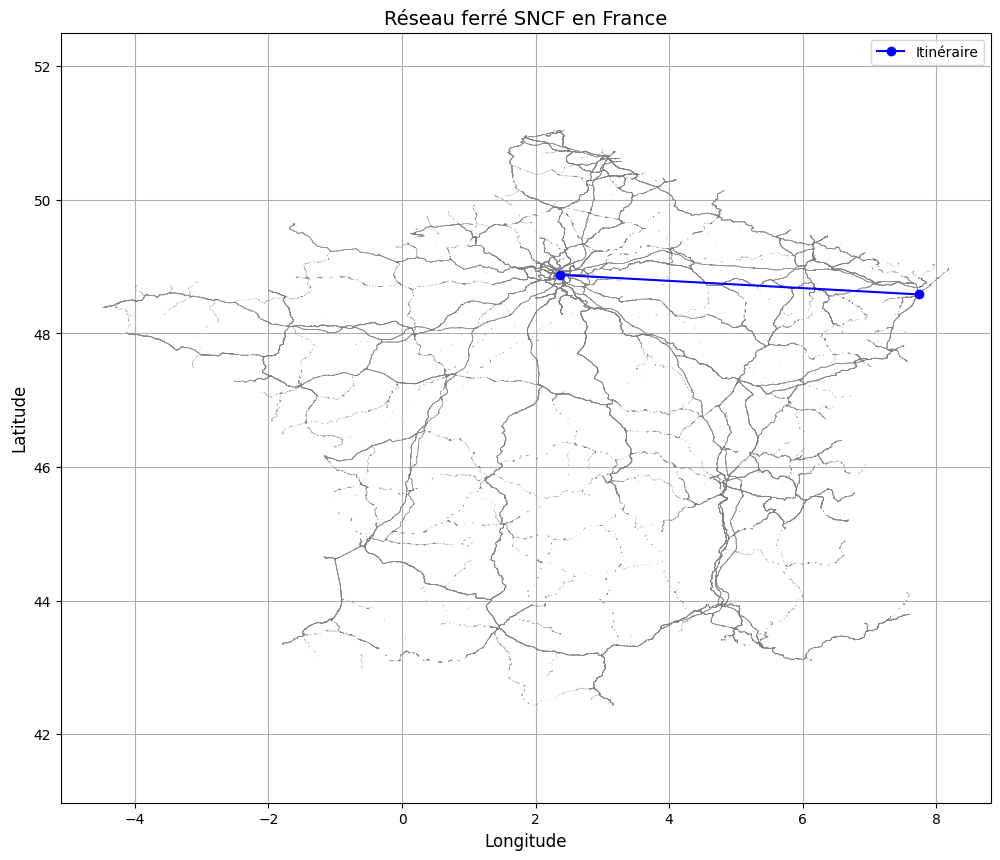

In [73]:
coordinates = []

if(route_info[0]['from'] in gares_dict):
    coordinates.append(gares_dict[route_info[0]['from']])

if(route_info[0]['to'] in gares_dict):
    coordinates.append(gares_dict[route_info[0]['to']])


lats_chemin, lons_chemin = zip(*coordinates)

plt.figure(figsize=(12, 10))

for segment in voies_segments:
    lons, lats = zip(*segment)
    plt.plot(lons, lats, color='gray', linewidth=0.5, alpha=0.7)

plt.plot(lons_chemin, lats_chemin, marker='o', color='blue', label='Itinéraire')  # Lignes et points

plt.title("Réseau ferré SNCF en France", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()